### Vertical Microstructure Profiler (VMP) data

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as scipy
import cmocean
import math
import gsw
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

plt.rcParams['font.size'] = '12'

In [2]:
workingdir = r'C:\Users\mijakes\checkouts\phd-public'
os.chdir(workingdir) 

import src.importData as imports
import src.calc as calc
import src.interpolation as interp
import src.plots as plots
import src.stats as stats
import src.concat as ct
import src.velocities as vel
import src.settings as settings

In [3]:
# Path to save figures
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter2_manuscript')

In [4]:
# Import satellite altimetry data 
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
alt_cmems = imports.importNetCDF(datadir, 'CMEMS.nc', datatype ='altimetry')

In [5]:
# Import VMP data 
vmp_ds = imports.importNetCDF(datadir, 'MR_vmp_2018_v2.nc', datatype ='vmp')

In [11]:
vmp_ds

<xarray.Dataset>
Dimensions:         (profile: 54, pressure: 3414, latitude: 54, longitude: 54, time_in: 54, time_out: 54, dynamic_height: 54, ctd_pressure: 2500, ctd_profile: 77)
Coordinates:
  * latitude        (latitude) float64 -49.84 -55.56 -55.56 ... -57.27 -57.13
  * longitude       (longitude) float64 149.4 150.8 150.8 ... 156.2 156.1 156.1
  * time_in         (time_in) datetime64[ns] 2018-10-17T21:42:00 ... 2018-11-...
  * time_out        (time_out) datetime64[ns] 2018-10-17T22:53:00 ... 2018-11...
  * dynamic_height  (dynamic_height) float64 2.03 0.8264 ... 0.9168 0.8963
  * ctd_pressure    (ctd_pressure) float64 2.0 4.0 6.0 ... 4.998e+03 5e+03
Dimensions without coordinates: profile, pressure, ctd_profile
Data variables:
    vmp_number      (profile) float64 1.0 2.0 2.0 3.0 ... 45.0 45.0 46.0 47.0
    epsilon         (profile, pressure) float64 ...
    chi             (profile, pressure) float64 ...
    sal             (profile, pressure) float64 ...
    temp            (profile, pressure) float64 ...
    gamma           (profile, pressure) float64 ...
    vmp_pressure    (profile, pressure) float64 ...
    mld             (profile) float64 37.25 29.25 26.75 ... 26.75 69.75 24.75
    ctd_sal         (ctd_profile, ctd_pressure) float64 ...
    ctd_temp        (ctd_profile, ctd_pressure) float64 ...
Attributes:
    Conventions:           CF-1.6
    Metadata_Conventions:  Unidata Dataset Discovery v1.0
    history:               Created on 05-Nov-2024 11:59:27 with to_netcdf.m
    title:                 Vertical microstructure profiler (VMP) data from M...
    summary:               Mixing measurements from the VMP along the CTD tra...
    project:               RV Investigator IN2018_V05
    creator_name:          Kurt L. Polzin
    institution:           Woods Hole Oceanographic Institution (WHOI) - Inst...
    date_created:          05-Nov-2024 11:59:19

In [96]:
N2, p_mid = gsw.Nsquared(vmp_ds.sal.transpose(), vmp_ds.temp.transpose(), vmp_ds.vmp_pressure.transpose(), vmp_ds.latitude[0])
N2, p_mid = N2.transpose(), p_mid.transpose()

In [113]:
mixing_eff = 0.2

In [118]:
### grid from 8dbar to 1800 dbar with 0.5 dbar intervals
p_grid = np.arange(8, 1800.5, 0.5)

shp = (len(vmp_ds.sal), len(p_grid))
S_gridded = np.ma.masked_all(shp)
T_gridded = np.ma.masked_all(shp)
eps_gridded = np.ma.masked_all(shp)
N2_gridded = np.ma.masked_all(shp)
kappa_gridded = np.ma.masked_all(shp)

for prof in range(len(vmp.sal)):

    S = vmp_ds.sal[prof].assign_coords(pressure = ('pressure', vmp_ds.vmp_pressure[prof].data))
    nonans = np.where(~np.isnan(S))[0]
    S_gridded[prof] = S[nonans].interp(pressure = p_grid)
    
    T = vmp_ds.temp[prof].assign_coords(pressure = ('pressure', vmp_ds.vmp_pressure[prof].data))
    nonans = np.where(~np.isnan(T))[0]
    T_gridded[prof] = T[nonans].interp(pressure = p_grid)
    
    n2 = xr.DataArray(N2[prof], dims = ["pressure"]).assign_coords(pressure = ('pressure', p_mid[prof]))
    nonans = np.where(~np.isnan(n2))[0]
    N2_gridded[prof] = n2[nonans].interp(pressure = p_grid)
    
    eps = vmp_ds.epsilon[prof].assign_coords(pressure = ('pressure', vmp_ds.vmp_pressure[prof].data))
    nonans = np.where(~np.isnan(eps))[0]
    eps_gridded[prof] = eps[nonans].interp(pressure = p_grid)
    
    kappa = mixing_eff*(eps[nonans]/n2[nonans].interp(pressure = eps[nonans].pressure))
    nonans = np.where(~np.isnan(kappa))[0]
    kappa_gridded[prof] = kappa[nonans].interp(pressure = p_grid)
    
S_gridded = xr.DataArray(S_gridded.data, dims = vmp_ds.sal.dims, coords = dict(pressure = ('pressure', p_grid)))
T_gridded = xr.DataArray(T_gridded.data, dims = vmp_ds.temp.dims, coords = dict(pressure = ('pressure', p_grid)))
N2_gridded = xr.DataArray(N2_gridded.data, dims = vmp_ds.temp.dims, coords = dict(pressure = ('pressure', p_grid)))
eps_gridded = xr.DataArray(eps_gridded.data, dims = vmp_ds.temp.dims, coords = dict(pressure = ('pressure', p_grid)))
kappa_gridded = xr.DataArray(kappa_gridded.data, dims = vmp_ds.temp.dims, coords = dict(pressure = ('pressure', p_grid)))

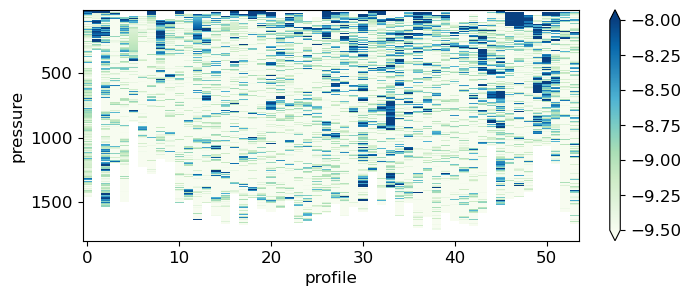

In [205]:
fig, ax = plt.subplots(figsize = (8, 3))
np.log10(eps_gridded).plot(x ='profile', vmin = -9.5, vmax = -8, cmap = 'GnBu')
ax.invert_yaxis()

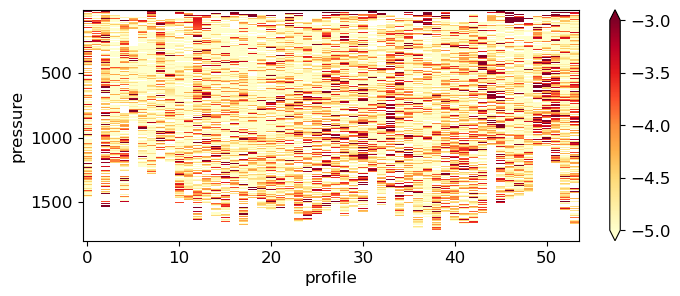

In [135]:
fig, ax = plt.subplots(figsize = (8, 3))
np.log10(kappa_gridded).plot(x ='profile', vmin = -5, vmax = -3, cmap = 'YlOrRd')
ax.invert_yaxis()

In [163]:
dsc, T_dens, S_dens = calc.DSC(T_gridded, S_gridded, x_smooth = False, dens_interval = 0.01)

calculating density...
interpolating to density grid


In [ ]:
pdens = calc.potentialDensity(T_gridded.pressure, S_gridded, T_gridded)

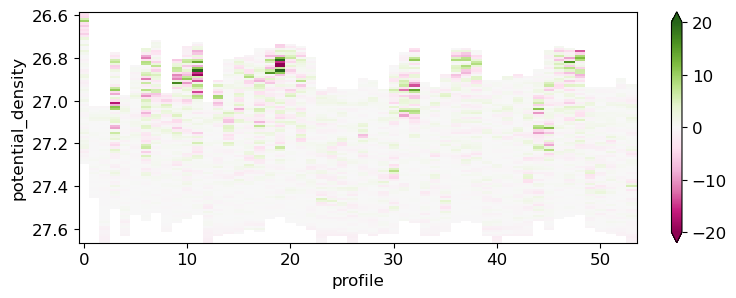

In [185]:
fig, ax = plt.subplots(figsize = (9,3))
dsc.plot(x = 'profile', cmap = 'PiYG', vmin = -20, vmax = 20)
ax.invert_yaxis()

In [211]:
ds = xr.Dataset(data_vars=dict(station = (["profile"], vmp_ds.vmp_number.data),
                               sal = (["profile", "pressure"], S_gridded.data),
                               temp = (["profile", "pressure"], T_gridded.data),
                               density = (["profile", "pressure"], pdens.data, {'desciption':'potential density referenced to the surface'}),
                               N2 = (["profile", "pressure"], N2_gridded.data),
                               epsilon =(["profile", "pressure"], eps_gridded.data, {'desciption':'TKE dissipation rate'}),
                               kappa =(["profile", "pressure"], kappa_gridded.data, {'desciption':'turbulent diffusivity'}),
                               dsc =(["profile", "potential_density"], dsc.data, {'desciption':'Diapycnal Spiciness Curvature'})),
                coords=dict(pressure=("pressure", S_gridded.pressure.data), 
                            potential_density = ("potential_density", dsc.potential_density.data),
                            time = ("time", vmp_ds.time_in.data),
                            latitude=("latitude", vmp_ds.latitude.data), 
                            longitude=("longitude", vmp_ds.longitude.data)),
                attrs=dict(description="Gridded VMP data and derived quantities from Macquarie Ridge meander Oct-Nov 2018"))

In [212]:
ds

<xarray.Dataset>
Dimensions:            (profile: 54, pressure: 3585, potential_density: 108, time: 54, latitude: 54, longitude: 54)
Coordinates:
  * pressure           (pressure) float64 8.0 8.5 9.0 ... 1.8e+03 1.8e+03
  * potential_density  (potential_density) float64 26.59 26.6 ... 27.65 27.66
  * time               (time) datetime64[ns] 2018-10-17T21:42:00 ... 2018-11-...
  * latitude           (latitude) float64 -49.84 -55.56 -55.56 ... -57.27 -57.13
  * longitude          (longitude) float64 149.4 150.8 150.8 ... 156.1 156.1
Dimensions without coordinates: profile
Data variables:
    station            (profile) float64 1.0 2.0 2.0 3.0 ... 45.0 45.0 46.0 47.0
    sal                (profile, pressure) float64 nan nan 34.48 ... nan nan nan
    temp               (profile, pressure) float64 nan nan 8.964 ... nan nan nan
    density            (profile, pressure) float64 nan nan 26.59 ... nan nan nan
    N2                 (profile, pressure) float64 nan nan nan ... nan nan nan
    epsilon            (profile, pressure) float64 nan 1.835e-05 ... nan nan
    kappa              (profile, pressure) float64 nan nan nan ... nan nan nan
    dsc                (profile, potential_density) float64 -3.155 ... -0.7936
Attributes:
    description:  Gridded VMP data and derived quantities from Macquarie Ridg...

In [217]:
filename = 'VMP_derived_variables.nc'
# ds.to_netcdf(os.path.join(datadir, 'vmp', filename))

In [218]:
vmp = xr.open_dataset(os.path.join(datadir, 'vmp', filename))

In [220]:
mld_on_d = calc.MLD_on_dens(vmp.density, criteria = 0.03, pref = 10, dz = 10)

In [221]:
dens_min = mld_on_d
dens_max = np.tile(27.5, len(mld_on_d))

# mean from 10dbar below the mixed layer to density of 27.5
avg_dsc_vmp = calc.mean_below_ml(abs(vmp.dsc), mld_on_d, zmax = 27.5)
avg_kappa_vmp = calc.average_in_density_on_pgrid(np.log10(vmp.kappa), pdens.data, dens_min.data, dens_max)
avg_eps_vmp = calc.average_in_density_on_pgrid(np.log10(vmp.epsilon), pdens.data, dens_min.data, dens_max)
avg_N2_vmp = calc.average_in_density_on_pgrid(vmp.N2, vmp.density.data, dens_min.data, dens_max)

### Load in other datasets

In [144]:
# EM-APEX floats
fltdir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
floatids = [8489, 8492, 8493]
ema = imports.importFloatData(floatids)

In [145]:
# Triaxus
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'triaxus')
folder = 'in2018_v05CtdAvgTriaxus_VerticalCasts_nc'

lst = ['01_002', '02_002', '02_005', '03_003', '04_002', '04_003', 
       '06_002', '07_002', '08_002', '08_003', '09_002', '09_003']

triaxus_cast = {}
for i in lst:
    file = 'in2018_v05_'+ i +'AvgCast.nc'
    triaxus_cast[i] = imports.importNetCDF(datadir, file, datatype = folder)

Text(0.5, 0, 'Longitude (°E)')

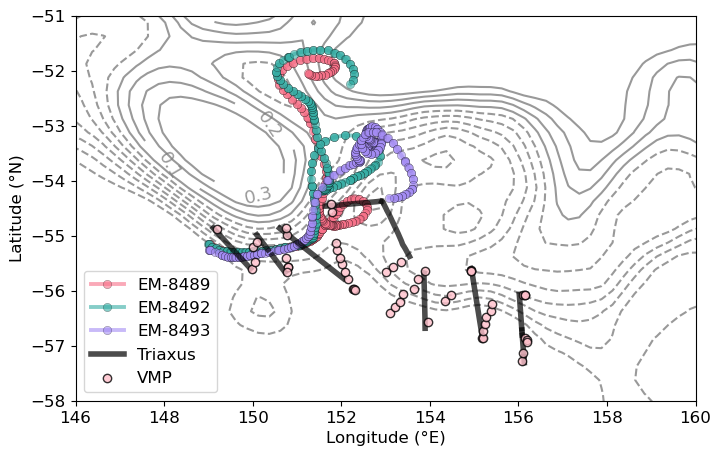

In [222]:
fig, ax = plt.subplots(figsize = (8, 5))

legend = []

start = vmp.time.values[0]
end = vmp.time.values[-1] 
start_time = str(start.astype('M8[D]'))
end_time = str(end.astype('M8[D]'))
mean_sea_level = alt_cmems.adt.sel(time = slice(start_time, end_time)).mean(dim = 'time')

# SSH contours
levels = np.arange(-0.7,0.4,0.1)
CS = mean_sea_level.plot.contour(colors = 'grey', linewidths = 1.5, alpha = 0.8, levels = levels)
plt.clabel(CS, inline=True, fontsize=13, fmt = '%1.1f')

pal = sns.color_palette("husl", 4)
cols = pal.as_hex()
cols = [cols[i] for i in [0, 2, 3]]

# EM-APEX floats
i = 0
for floatid in floatids:
    rs = calc.findRSperiod(ema[floatid])
    ax.plot(ema[floatid].longitude[rs], ema[floatid].latitude[rs],'.-', 
            linewidth = 2.8, markersize=12, c = cols[i], markeredgecolor='k', 
            markeredgewidth= 0.25, alpha = 0.6, zorder = 5)
    legend.append(f'EM-{floatid}')
    i+=1

# Triaxus
lon = triaxus_cast[lst[0]].longitude
lat = triaxus_cast[lst[0]].latitude
plt.plot(lon, lat, c = 'k', alpha = 0.7, linewidth = 4, zorder = 10)
legend.append(f'Triaxus')

# VMP profiles
plt.scatter(vmp.longitude, vmp.latitude, zorder = 11, edgecolors = 'k', facecolors = 'pink', alpha = 0.8)
legend.append(f'VMP')

ax.legend(legend, loc = 'lower left', prop={'size': 12})

for i in lst[1:]:
    lon = triaxus_cast[i].longitude
    lat = triaxus_cast[i].latitude
    plt.plot(lon, lat, c = 'k', alpha = 0.7, linewidth = 4, zorder = 10)

ax.set_ylim(-58, -51)
ax.set_xlim(146, 160)

plt.ylabel(u'Latitude (\N{DEGREE SIGN}N)')
plt.xlabel(u'Longitude (\N{DEGREE SIGN}E)')
# plt.title('VMP profiles')

In [9]:
# settings.save_figure(fig, my_path, 'flt_vmp_map.png', dpi = 600, pad = 0.2)

In [226]:
print(start_time, end_time)

2018-10-17 2018-11-09


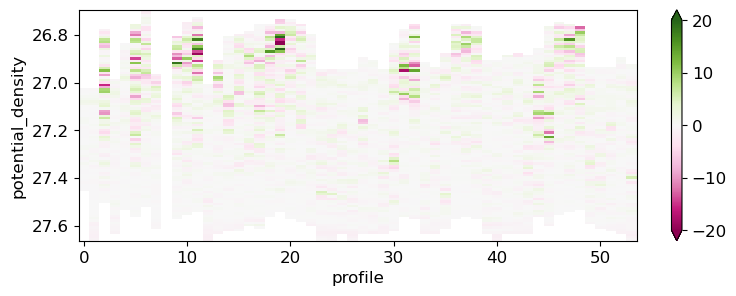

In [29]:
fig, ax = plt.subplots(figsize = (9,3))
dsc.plot(x = 'profile', cmap = 'PiYG', vmin = -20, vmax = 20)
ax.invert_yaxis()

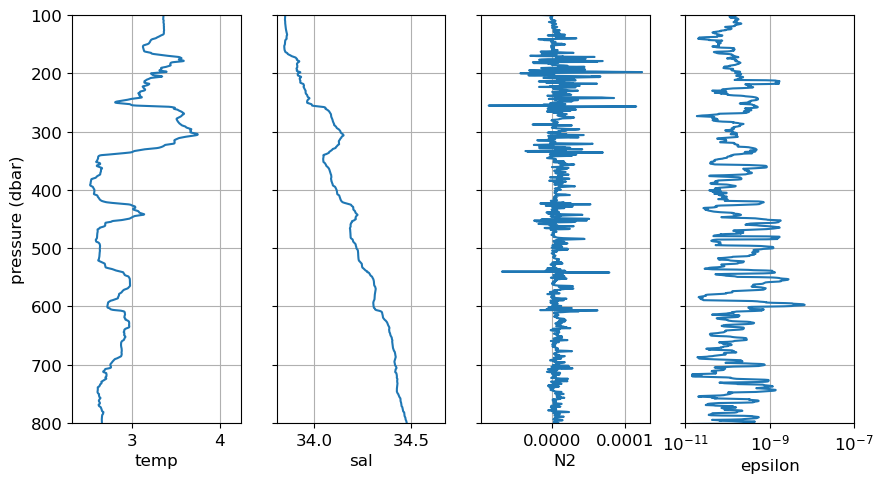

In [234]:
prof = 3

fig, ax = plt.subplots(1, 4, sharey = True, figsize = (9, 5))
axs = ax.flatten()

vmp.temp[prof].plot(ax = axs[0], y = 'pressure')
axs[0].set_ylim(100, 800)
axs[0].invert_yaxis()
# axs[0].set_title(f'VMP prof {prof+1}')

vmp.sal[prof].plot(ax = axs[1], y = 'pressure')

vmp.N2[prof].plot(ax = axs[2], y = 'pressure')
axs[2].set_xlabel('N2')

vmp.epsilon[prof].plot(ax = axs[3], y = 'pressure')
axs[3].set_xscale('log')
axs[3].set_xlim(1e-11, 1e-7)

for i in range(len(axs)):
    axs[i].grid()
    axs[i].set_ylabel('')
    
axs[0].set_ylabel('pressure (dbar)')
    
plt.tight_layout(w_pad = 0.3)

(-22.0, 22.0)

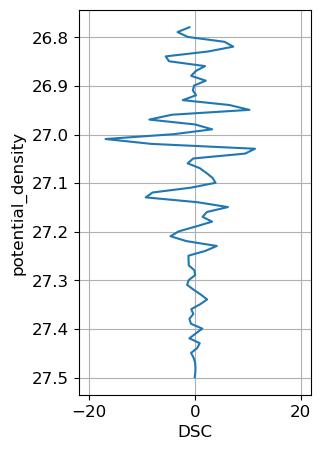

In [235]:
fig, ax = plt.subplots(figsize = (3, 5))
dsc[prof].plot(y = 'potential_density')
ax.invert_yaxis()
ax.set_xlabel('DSC')
plt.grid()
plt.xlim(-22, 22)

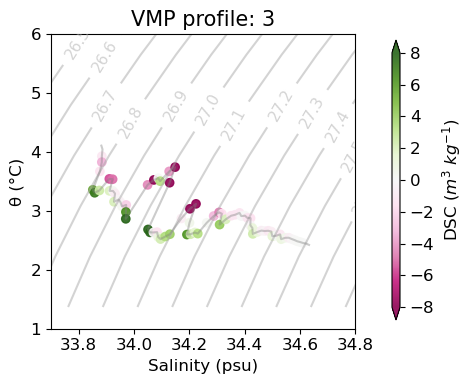

In [240]:
t = T_dens[prof]
s = S_dens[prof]
col = dsc[prof]

ti, si, dens_contour = calc.tsDensContour(s, t)


fig, ax = plt.subplots(figsize = (4,4))
ax.plot(s,t, alpha = 0.4, c ='grey')
im = ax.scatter(s, t, c = col, cmap = 'PiYG', alpha = 0.9, vmin = -8, vmax = 8)

CS = ax.contour(si, ti, dens_contour, levels = np.arange(26.4, 27.9, 0.1), colors='darkgrey', alpha = 0.5)
plt.clabel(CS, inline=1, fontsize=11, fmt = '%1.1f')

ax.set_title(f'VMP profile: {int(vmp.station[prof].data)}', fontsize = 15)
ax.set_ylabel('\u03B8 (\N{DEGREE SIGN}C)')
ax.set_xlabel('Salinity (psu)')
ax.set_xlim(33.7, 34.8)
ax.set_ylim(1, 6)


plt.tight_layout(w_pad = 1.2)

cax = plt.axes([1, 0.18, 0.02, 0.7])
plt.colorbar(im, cax = cax,label =('DSC ($m^{3}$ $kg^{-1}$)'), extend = 'both')

Text(0.5, 1.0, 'VMP profiles')

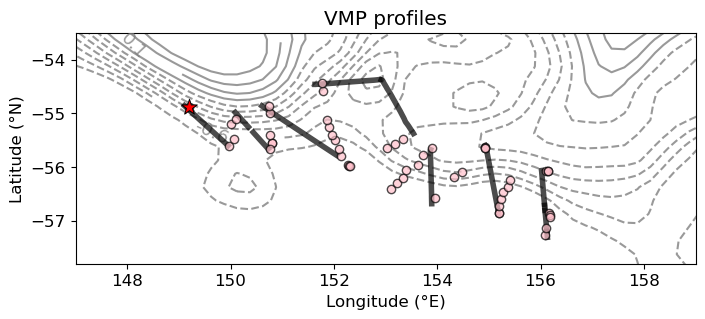

In [247]:
lt, ln = vmp.latitude, vmp.longitude

fig, ax = plt.subplots(figsize = (8, 3))

start = vmp.time.values[0]
end = vmp.time.values[-1] 
start_time = str(start.astype('M8[D]'))
end_time = str(end.astype('M8[D]'))
mean_sea_level = alt_cmems.adt.sel(time = slice(start_time, end_time)).mean(dim = 'time')

# SSH contours
levels = np.arange(-0.7,0.4,0.1)
CS = mean_sea_level.plot.contour(colors = 'grey', linewidths = 1.5, alpha = 0.8, levels = levels)
plt.clabel(CS, inline=True, fontsize=13, fmt = '%1.1f')

for i in lst:
    lon = triaxus_cast[i].longitude
    lat = triaxus_cast[i].latitude
    plt.plot(lon, lat, c = 'k', alpha = 0.7, linewidth = 4, zorder = 10)

plt.scatter(ln, lt, zorder = 11, edgecolors = 'k', facecolors = 'pink', alpha = 0.7)

plt.scatter(ln[prof], lt[prof], zorder = 11,  edgecolors = 'k', marker = '*', s = 140,
            linewidths = 0.7, facecolors = 'red')


ax.set_ylim(-57.8, -53.5)
ax.set_xlim(147, 159)

plt.ylabel(u'Latitude (\N{DEGREE SIGN}N)')
plt.xlabel(u'Longitude (\N{DEGREE SIGN}E)')
plt.title('VMP profiles')

In [47]:
high_dsc_prof = int((vmp.dyn_m_sorted-1).sel(dynamic_height = 0.73, method = 'nearest')) #0.7
low_dsc_prof = int((vmp.dyn_m_sorted-1).sel(dynamic_height = 0.45, method = 'nearest')) #0.53

In [250]:
high_dsc_prof = 3
low_dsc_prof = 26

In [251]:
# pdens2 = calc.potentialDensity(vmp.pressure, vmp.salinity, vmp.temperature)
# k_dens = interp.to_pdens_grid(vmp.diffusivity, pdens2, dens_interval = 0.01)
# e_dens = interp.to_pdens_grid(vmp.epsilon, pdens2, dens_interval = 0.01)

Text(0.5, 0.94, 'VMP profiles 3 (high DSC) & 26 (low DSC)')

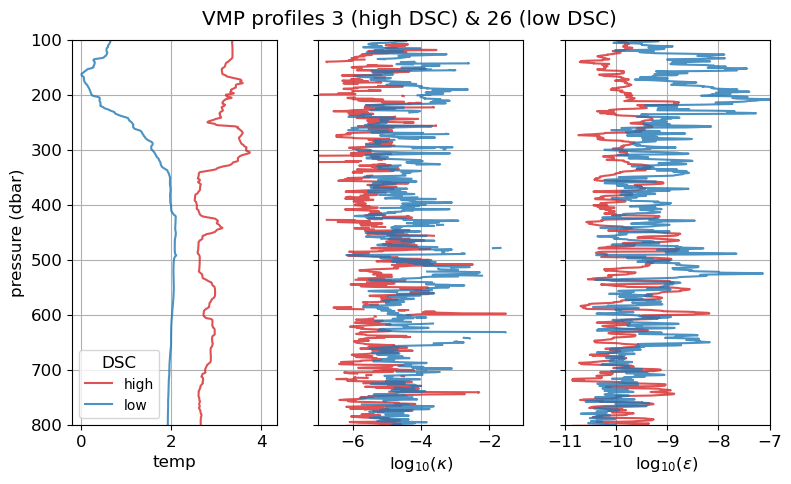

In [253]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (9, 5))
vmp.temp[high_dsc_prof].plot(ax = ax1, y = 'pressure', c = 'tab:red', alpha = 0.8)
vmp.temp[low_dsc_prof].plot(ax = ax1, y = 'pressure', c = 'tab:blue', alpha = 0.8)
ax1.set_ylim(100,800)
ax1.invert_yaxis()
ax1.set_ylabel('pressure (dbar)')
ax1.legend(['high', 'low'], title = 'DSC', fontsize = 10, loc = 'lower left')
ax1.grid()


np.log10(vmp.kappa)[high_dsc_prof].plot(ax = ax2, y = 'pressure', c = 'tab:red', alpha = 0.8)
np.log10(vmp.kappa)[low_dsc_prof].plot(ax = ax2, y = 'pressure', c = 'tab:blue', alpha = 0.8)
ax2.set_xlim(-7, -1)
ax2.grid()
ax2.set_xlabel('log$_{10}$($\kappa$)')
ax2.set_ylabel('')


np.log10(vmp.epsilon)[high_dsc_prof].plot(ax = ax3, y = 'pressure', c = 'tab:red', alpha = 0.8)
np.log10(vmp.epsilon)[low_dsc_prof].plot(ax = ax3, y = 'pressure', c = 'tab:blue', alpha = 0.8)
ax3.set_xlim(-11, -7)
ax3.grid()
ax3.set_xlabel('log$_{10}$($\epsilon$)')
ax3.set_ylabel('')

fig.suptitle(f'VMP profiles {int(vmp.station[high_dsc_prof].data)} (high DSC) & {int(vmp.station[low_dsc_prof].data)} (low DSC)', y=0.94)

In [254]:
# settings.save_figure(fig, my_path, 'vmp_example_1.png', dpi = 600, pad = 0.2)

### Internal wave-driven mixing from EM-APEX floats using finescale parameterisation

In [146]:
rot_vels = {}
for floatid in floatids:
    #rotated velocities
    file = os.path.join(fltdir, 'rotated_velocity', 'by_profile', 'rot_vel_%s.nc' %floatid)
    rot_vels[floatid] = xr.open_dataset(file)

# half-inertial pair averaged float dataset
ds = imports.sub_inertial_ds(ema, floatids, fltdir, xdim = 'distance', rot_vels = rot_vels)

In [147]:
# import Ajitha's mixing estimes (diffusivity and dissipation rates)
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
mixing_ds = imports.importNetCDF(datadir, 'mixing_estimates_ajitha.nc', datatype ='mixing_ajitha')

In [148]:
def remove_drift(var):
    # remove drift profiles
    ind = []
    for i in range(0, len(var)):
        nans = np.where(np.isnan(var[i]))[0]
        if len(nans) != len(var[i]):
            ind.append(i)
    return var[ind], ind

In [149]:
dens = {}
mld_on_d = {}
CT, SA = {}, {}
N2 = {}
kappa = {}
epsilon = {}

for floatid in floatids:
    rs = calc.findRSperiod(ema[floatid])
    CT[floatid], SA[floatid] = ds[floatid].CT, ds[floatid].SA
    N2[floatid] = calc.N2(CT[floatid], SA[floatid], ds[floatid].latitude, smooth = False)
    pressure = np.tile(ds[floatid].pressure, (len(ds[floatid].CT), 1))
    ds[floatid]['P'] = xr.DataArray(pressure, dims = ds[floatid].CT.dims, coords = ds[floatid].CT['pressure'].coords)
    
    dens[floatid] = calc.potentialDensity(ds[floatid].P, ds[floatid].SA, ds[floatid].CT)
    mld_on_d[floatid] = calc.MLD_on_dens(dens[floatid], criteria = 0.03, pref = 10)
    
    data_k = mixing_ds[f'diffusivity{str(floatid)[-2:]}'][rs]
    data_e = mixing_ds[f'epsilon{str(floatid)[-2:]}'][rs]

    xdim = f'profile{str(floatid)[-2:]}'
    prof = np.arange(0,len(data_k))
    data_k[xdim] = prof
    data_e[xdim] = prof
    
    n = slice(0, len(prof))

    k = xr.DataArray(np.log10(data_k)[n].data, dims = ['distance', 'pressure'], coords = dict(pressure = ('pressure', data_k.pressure.data),
                                                                              distance = ('distance', ds[floatid].distance[n].data)))
    
    e = xr.DataArray(np.log10(data_e)[n].data, dims = ['distance', 'pressure'], coords = dict(pressure = ('pressure', data_e.pressure.data),
                                                                          distance = ('distance', ds[floatid].distance[n].data)))
    
    k = interp.new_pressure_grid(k, ds[floatid].pressure, zdim = 'pressure')
    e = interp.new_pressure_grid(e, ds[floatid].pressure, zdim = 'pressure')
    
    kappa[floatid] = k
    epsilon[floatid] = e
    

In [150]:
kappa_ct = ct.joinFloats(kappa, 'distance', new_dim = True)
kappa_ct, ind = remove_drift(kappa_ct)
eps_ct = ct.joinFloats(epsilon, 'distance', new_dim = True)
eps_ct, ind = remove_drift(eps_ct)

In [151]:
pdens_ct = ct.joinFloats(dens, 'distance', new_dim = False)

In [153]:
S_concat = ct.joinFloats(SA, 'distance', new_dim = False)
T_concat = ct.joinFloats(CT, 'distance', new_dim = False)
Sdens_ds, end_dist, d_rs = ct.concatenated_flts(SA, floatids, interp_to_dens = True, pdens = pdens_ct, new_dim = False, rs = False)
Tdens_ds, end_dist, d_rs = ct.concatenated_flts(CT, floatids, interp_to_dens = True, pdens = pdens_ct, new_dim = False, rs = False)

ticks, values, flt_dist_loc = plots.concatTickValues(d_rs)
flt_ind = np.where(Sdens_ds.distance == 0)[0].tolist()
flt_ind.append(len(Sdens_ds))

In [154]:
DSC = {}
DSC_smooth = {}
S_dens, T_dens = {}, {}
p_on_dens = {}

i = 0 
for floatid in floatids:
    
    S = Sdens_ds[flt_ind[i]:flt_ind[i+1]]
    T = Tdens_ds[flt_ind[i]:flt_ind[i+1]]
    density = pdens_ct[flt_ind[i]:flt_ind[i+1]]
    S_dens[floatid], T_dens[floatid] = S, T

    DSC[floatid], DSC_smooth[floatid] = calc.DSC(T, S, pdens = density, dens_interval = 0.01)
    
    p_on_dens[floatid] = interp.to_pdens_grid(ds[floatid].P, density, zdim = 'pressure', dens_interval = 0.01)
    
    i += 1

In [155]:
DSC_concat = ct.joinFloats(DSC_smooth, 'distance', new_dim = True)
N2_concat = ct.joinFloats(N2, 'distance', new_dim = True)

In [156]:
mld_on_d = {}
mld = {}
for floatid in floatids:
    mld_on_d[floatid] = calc.MLD_on_dens(dens[floatid], criteria = 0.03, pref = 10, dz = 10) #10 dbar below ML  
    mld[floatid] = calc.MLD(dens[floatid], criteria = 0.03, pref = 10) - 10 #10 dbar below ML  
    
mld_dens_concat = ct.joinFloats(mld_on_d, 'distance', new_dim = True)
mld_ct = ct.joinFloats(mld, 'distance', new_dim = True)

In [157]:
# mean below the mixed layer to 27.5 kg/m3
dens_min = mld_dens_concat
dens_max = np.tile(27.5, len(dens_min))

avg_kappa = calc.average_in_density_on_pgrid(kappa_ct, pdens_ct[ind].data, dens_min.data, dens_max)
avg_eps = calc.average_in_density_on_pgrid(eps_ct, pdens_ct[ind].data, dens_min.data, dens_max)
avg_N2 = calc.average_in_density_on_pgrid(N2_concat, pdens_ct.data, dens_min.data, dens_max)

In [158]:
# mean below the mixed layer to 27.5 kg/m3
avg_dsc = calc.mean_below_ml(abs(DSC_concat), mld_dens_concat, zmax = 27.5)

In [159]:
all_N2 = np.concatenate((avg_N2[ind], avg_N2_vmp))
N2_cutoff = np.nanmean(all_N2)
N2_cutoff

1.0023140232247896e-05

Pearsons corr: -0.571, p-value: 2.64e-56
Pearsons corr: -0.611, p-value: 3.2e-35


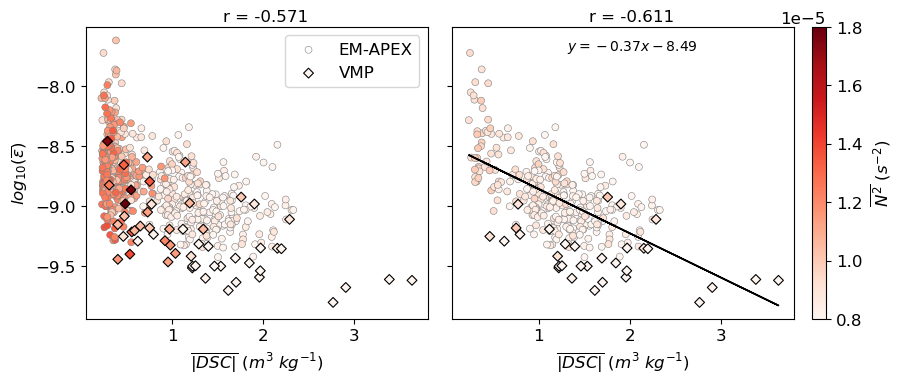

In [170]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize = (8.2,4))

# EM-APEX data
x_flt = avg_dsc[ind]
y_flt = avg_eps
c_flt = avg_N2[ind]

im1 = ax1.scatter(x_flt, y_flt, c = c_flt, s= 25, marker = 'o', cmap = 'Reds', 
                vmin = 8e-6, vmax = 1.8e-5, edgecolors = 'grey', linewidth = 0.4)

# VMP data
x_vmp = avg_dsc_vmp
y_vmp = avg_eps_vmp
c_vmp = avg_N2_vmp

ax1.scatter(x_vmp, y_vmp, c = c_vmp, s= 25, marker = 'D',  cmap = 'Reds', 
                 vmin = 8e-6, vmax = 1.8e-5, edgecolors = 'k', linewidths = 0.8)

ax1.legend(['EM-APEX', 'VMP'], fontsize = 12)

ax1.set_ylabel('$log_{10}(\overline{\epsilon})$')
ax1.set_xlabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

all_dsc = np.concatenate((x_flt, x_vmp))
all_eps = np.concatenate((y_flt, y_vmp))

r, p = stats.pearsons(all_dsc, all_eps, print_info = True)
ax1.text(0.4, 1.02, f'r = {r:.3f}', transform = ax1.transAxes)


## Low N2 cutoff
all_N2 = np.concatenate((avg_N2[ind], avg_N2_vmp))
N2_cutoff = np.nanmean(all_N2)

# EM-APEX data
low_N2 = np.where(avg_N2[ind] < N2_cutoff)[0]
x_flt = avg_dsc[ind][low_N2]
y_flt = avg_eps[low_N2]
c_flt = avg_N2[ind][low_N2]

ax2.scatter(x_flt, y_flt, c = c_flt, s= 25, marker = 'o', cmap = 'Reds', 
                vmin = 8e-6, vmax = 1.8e-5, edgecolors = 'grey', linewidth = 0.4)

# VMP data
low_N2 = np.where(avg_N2_vmp < N2_cutoff)[0]
x_vmp = avg_dsc_vmp[low_N2]
y_vmp = avg_eps_vmp[low_N2]
c_vmp = avg_N2_vmp[low_N2]

ax2.scatter(x_vmp, y_vmp, c = c_vmp, s= 25, marker = 'D',  cmap = 'Reds', 
                 vmin = 8e-6, vmax = 1.8e-5, edgecolors = 'k', linewidths = 0.8)

ax2.set_ylabel('')
ax2.set_xlabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

all_dsc = np.concatenate((x_flt, x_vmp))
all_eps = np.concatenate((y_flt, y_vmp))

#linear fit
nonans = np.where(~np.isnan(all_dsc*all_eps))[0]
m, b = np.polyfit(all_dsc[nonans], all_eps[nonans], 1)
yfit = [(m * xi) + b for xi in all_dsc[nonans]]
ax2.plot(all_dsc[nonans], yfit, c = 'k', linewidth = 1.2)
line = f'$y = {m:.2f}x {b:.2f}$'
ax2.text(0.335, 0.92, line, transform = ax2.transAxes, fontsize = 10)

r, p = stats.pearsons(all_dsc, all_eps, print_info = True)
ax2.text(0.4, 1.02, f'r = {r:.3f}', transform = ax2.transAxes)

plt.tight_layout(w_pad = 1.2)

cax = plt.axes([1, 0.18, 0.017, 0.73])
plt.colorbar(im1, cax = cax, label =('$\overline{N^{2}}$ $(s^{-2})$'))

# settings.save_figure(fig, my_path, 'flt_vmp_DSC_eps_scatter.png', dpi = 600, pad = 0.2)

Pearsons corr: -0.441, p-value: 1.56e-31
Pearsons corr: -0.582, p-value: 2.89e-31


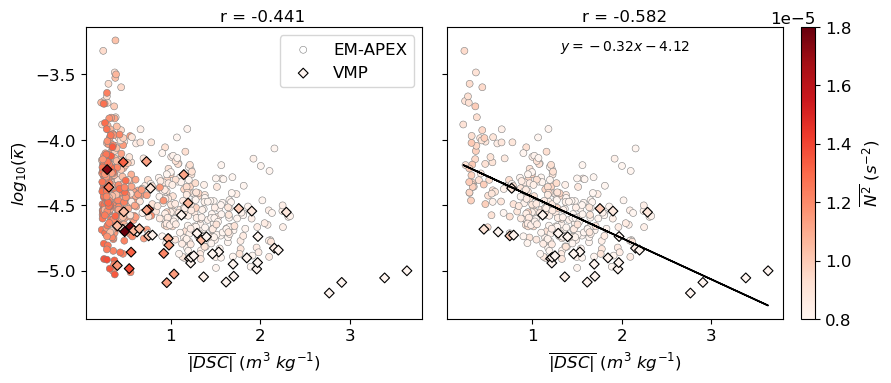

In [169]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize = (8.2,4))

# EM-APEX data
x_flt = avg_dsc[ind]
y_flt = avg_kappa 
c_flt = avg_N2[ind]

im1 = ax1.scatter(x_flt, y_flt, c = c_flt, s= 25, marker = 'o', cmap = 'Reds', 
                vmin = 8e-6, vmax = 1.8e-5, edgecolors = 'grey', linewidth = 0.4)

# VMP data
x_vmp = avg_dsc_vmp
y_vmp = avg_kappa_vmp
c_vmp = avg_N2_vmp #vmp_lon

ax1.scatter(x_vmp, y_vmp, c = c_vmp, s= 25, marker = 'D',  cmap = 'Reds', 
                 vmin = 8e-6, vmax = 1.8e-5, edgecolors = 'k', linewidths = 0.8)

ax1.legend(['EM-APEX', 'VMP'], fontsize = 12)

ax1.set_ylabel('$log_{10}(\overline{\kappa})$')
ax1.set_xlabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

all_dsc = np.concatenate((x_flt, x_vmp))
all_kappa = np.concatenate((y_flt, y_vmp))

r, p = stats.pearsons(all_dsc, all_kappa, print_info = True)
ax1.text(0.4, 1.02, f'r = {r:.3f}', transform = ax1.transAxes)


## Low N2 cutoff
all_N2 = np.concatenate((avg_N2[ind], avg_N2_vmp))
N2_cutoff = np.nanmean(all_N2)


# EM-APEX data
low_N2 = np.where(avg_N2[ind] < N2_cutoff)[0]
x_flt = avg_dsc[ind][low_N2]
y_flt = avg_kappa[low_N2]
c_flt = avg_N2[ind][low_N2]

ax2.scatter(x_flt, y_flt, c = c_flt, s= 25, marker = 'o', cmap = 'Reds', 
                vmin = 8e-6, vmax = 1.8e-5, edgecolors = 'grey', linewidth = 0.4)

# VMP data
low_N2 = np.where(avg_N2_vmp < N2_cutoff)[0]
x_vmp = avg_dsc_vmp[low_N2]
y_vmp = avg_kappa_vmp[low_N2]
c_vmp = avg_N2_vmp[low_N2] #vmp_lon[low_N2]

ax2.scatter(x_vmp, y_vmp, c = c_vmp, s= 25, marker = 'D',  cmap = 'Reds', 
                 vmin = 8e-6, vmax = 1.8e-5, edgecolors = 'k', linewidths = 0.8)

ax2.set_ylabel('')
ax2.set_xlabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

all_dsc = np.concatenate((x_flt, x_vmp))
all_kappa = np.concatenate((y_flt, y_vmp))

#linear fit
nonans = np.where(~np.isnan(all_dsc*all_kappa))[0]
m, b = np.polyfit(all_dsc[nonans], all_kappa[nonans], 1)
yfit = [(m * xi) + b for xi in all_dsc[nonans]]
ax2.plot(all_dsc[nonans], yfit, c = 'k', linewidth = 1.2)
line = f'$y = {m:.2f}x {b:.2f}$'
ax2.text(0.335, 0.92, line, transform = ax2.transAxes, fontsize = 10)

r, p = stats.pearsons(all_dsc, all_kappa, print_info = True)
ax2.text(0.4, 1.02, f'r = {r:.3f}', transform = ax2.transAxes)

plt.tight_layout(w_pad = 1.2)

cax = plt.axes([1, 0.18, 0.017, 0.73])
plt.colorbar(im1, cax = cax, label =('$\overline{N^{2}}$ $(s^{-2})$'))

# settings.save_figure(fig, my_path, 'flt_vmp_DSC_K_scatter.png', dpi = 600, pad = 0.2)